In [13]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [19]:
import gc
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
np.random.seed(2018)
warnings.filterwarnings('ignore')

# Credit to https://www.kaggle.com/gpreda/jigsaw-eda

In [20]:
train_data = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id')
test_data = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id')
sample_submission = pd.read_csv('jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

In [21]:
train_data.head(100)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59
59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
239575,0.000000,The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4


Get a count of the data for each dataset

In [22]:
print(train_data.shape)
print(test_data.shape)

(1804874, 44)
(97320, 1)


See how many null values we are dealing with per column

In [24]:
train_data.isnull().sum()

target                                 0      
comment_text                           0      
severe_toxicity                        0      
obscene                                0      
identity_attack                        0      
insult                                 0      
threat                                 0      
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

Percent of our target feature. Mostly benign comments. Right skewed. 

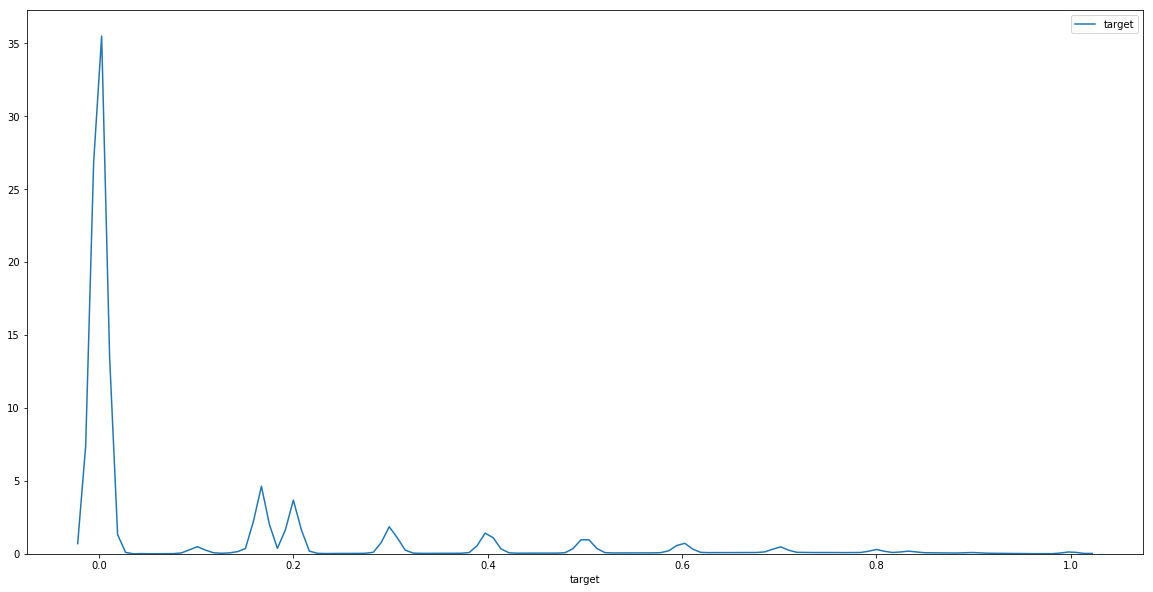

In [29]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['target'], hist=False, label='target')
plt.show()

Plot all toxic features. Insult seems the most common

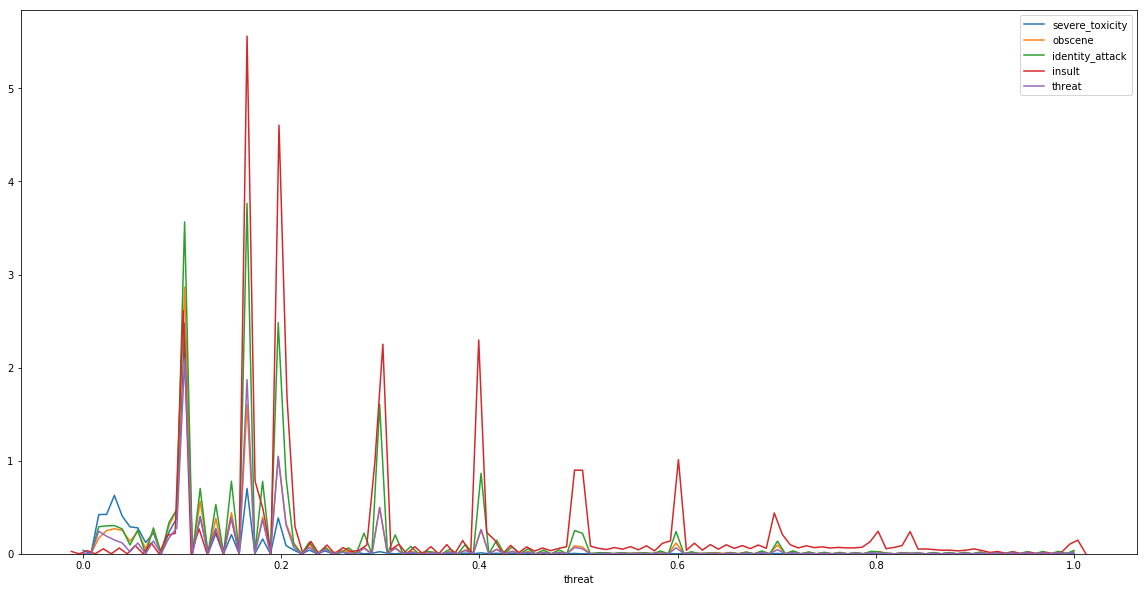

In [31]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['severe_toxicity'], hist=False, label='severe_toxicity')
sns.distplot(train_data['obscene'], hist=False, label='obscene')
sns.distplot(train_data['identity_attack'], hist=False, label='identity_attack')
sns.distplot(train_data['insult'], hist=False, label='insult')
sns.distplot(train_data['threat'], hist=False, label='threat')
plt.show()

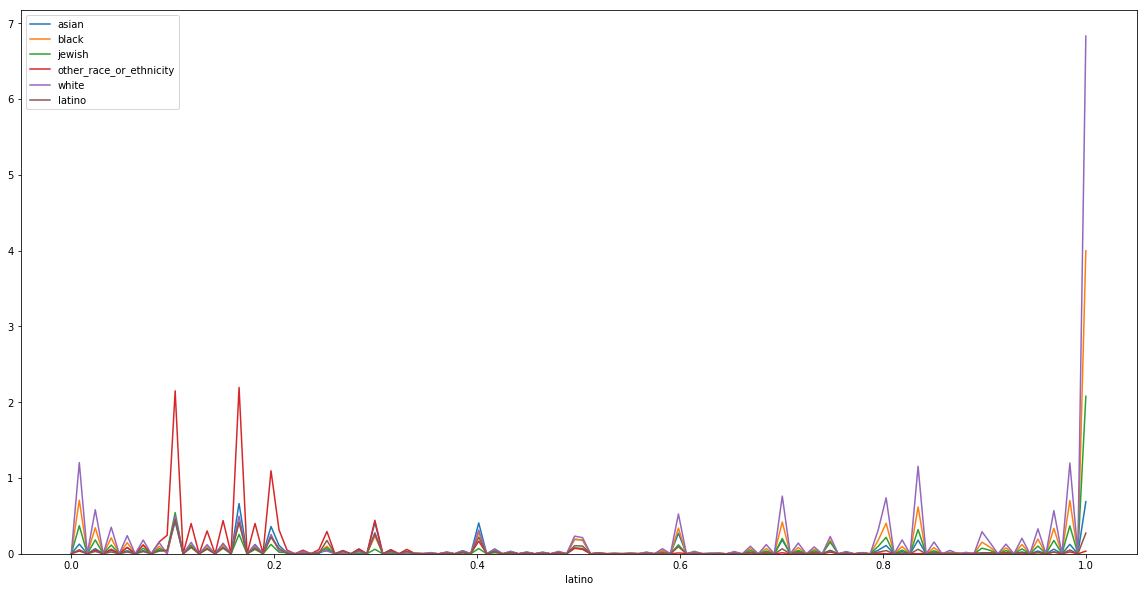

In [33]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['asian'], hist=False, label='asian')
sns.distplot(train_data['black'], hist=False, label='black')
sns.distplot(train_data['jewish'], hist=False, label='jewish')
sns.distplot(train_data['other_race_or_ethnicity'], hist=False, label='other_race_or_ethnicity')
sns.distplot(train_data['white'], hist=False, label='white')
sns.distplot(train_data['latino'], hist=False, label='latino')
plt.show()

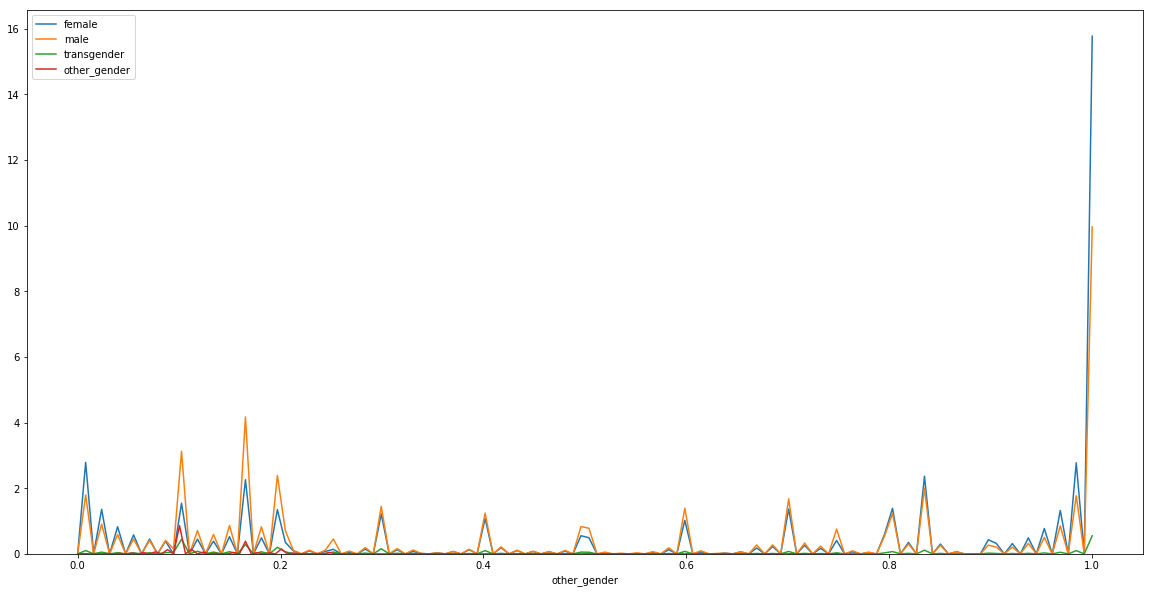

In [34]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['female'], hist=False, label='female')
sns.distplot(train_data['male'], hist=False, label='male')
sns.distplot(train_data['transgender'], hist=False, label='transgender')
sns.distplot(train_data['other_gender'], hist=False, label='other_gender')
plt.show()

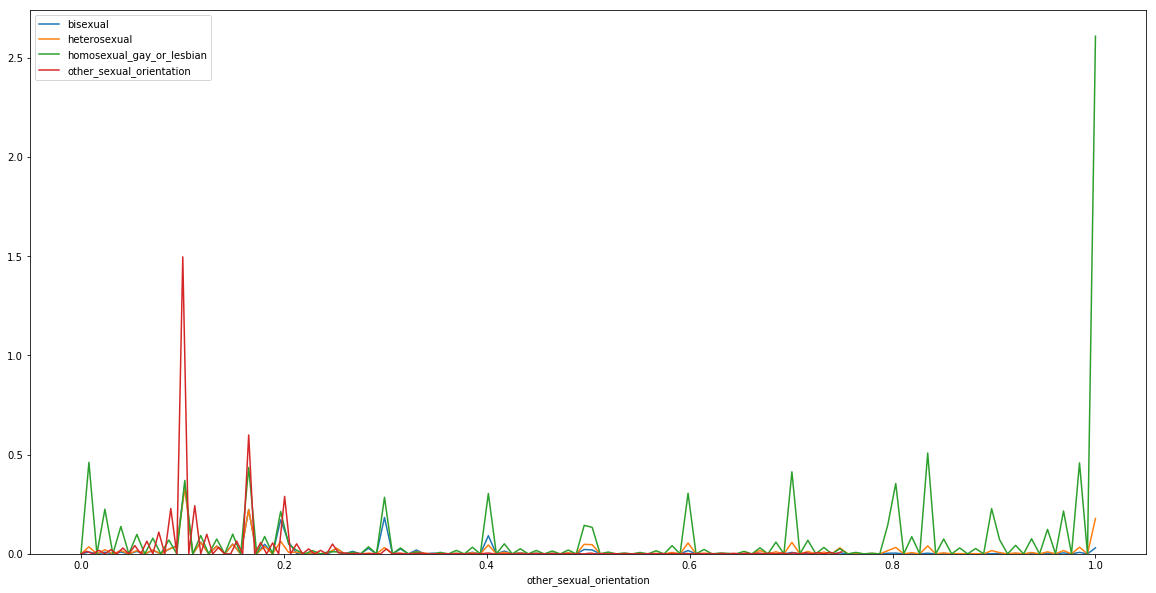

In [36]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['bisexual'], hist=False, label='bisexual')
sns.distplot(train_data['heterosexual'], hist=False, label='heterosexual')
sns.distplot(train_data['homosexual_gay_or_lesbian'], hist=False, label='homosexual_gay_or_lesbian')
sns.distplot(train_data['other_sexual_orientation'], hist=False, label='other_sexual_orientation')
plt.show()

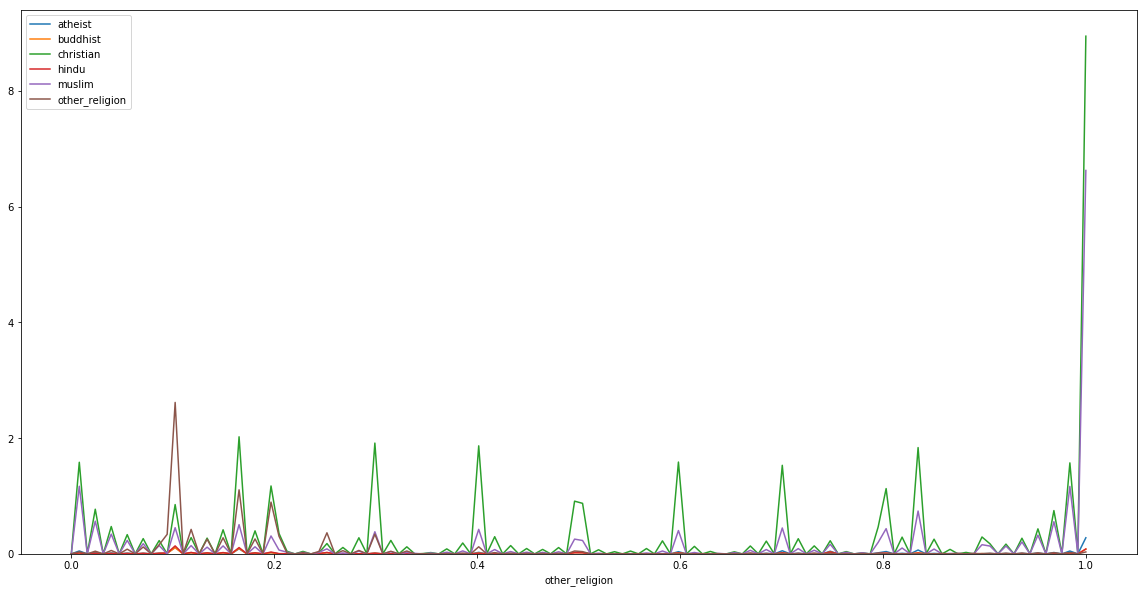

In [37]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['atheist'], hist=False, label='atheist')
sns.distplot(train_data['buddhist'], hist=False, label='buddhist')
sns.distplot(train_data['christian'], hist=False, label='christian')
sns.distplot(train_data['hindu'], hist=False, label='hindu')
sns.distplot(train_data['muslim'], hist=False, label='muslim')
sns.distplot(train_data['other_religion'], hist=False, label='other_religion')
plt.show()

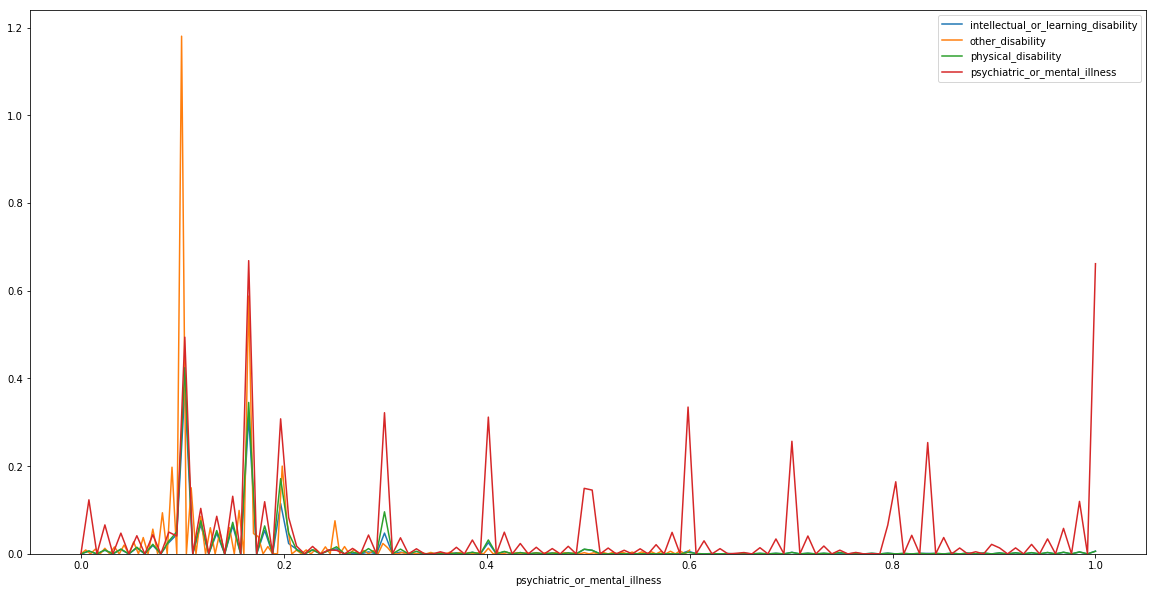

In [38]:
plt.figure(figsize=(20,10))
sns.distplot(train_data['intellectual_or_learning_disability'], hist=False, label='intellectual_or_learning_disability')
sns.distplot(train_data['other_disability'], hist=False, label='other_disability')
sns.distplot(train_data['physical_disability'], hist=False, label='physical_disability')
sns.distplot(train_data['psychiatric_or_mental_illness'], hist=False, label='psychiatric_or_mental_illness')
plt.show()